In [7]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  1.4.1     v purrr   0.2.4
v tidyr   0.7.2     v dplyr   0.7.4
v readr   1.1.1     v stringr 1.2.0
v tibble  1.4.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::extract() masks rstan::extract()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()


In [8]:
list.files(path = ".")

[1] "data"                       "presence_questionnaire.csv"
[3] "scanpath.ipynb"

In [9]:
# pq <- read.csv("/kaggle/input/presence-questionnaire/presence_questionnaire.csv", comment.char="#")
pq <- read.csv("./presence_questionnaire.csv", comment.char="#")

In [10]:
list.files("./data")

[1] "100" "101" "102" "103" "104" "105" "106" "107" "108" "109" "110" "111"
[13] "112" "113" "114" "115" "116" "117" "118" "119" "120" "121" "122" "123"
[25] "124" "126" "127" "128" "129"

In [11]:
child_dirs <- list.files("./data")
child_dirs

[1] "100" "101" "102" "103" "104" "105" "106" "107" "108" "109" "110" "111"
[13] "112" "113" "114" "115" "116" "117" "118" "119" "120" "121" "122" "123"
[25] "124" "126" "127" "128" "129"

In [12]:
child_dir = child_dirs[4]
f <- list.files(paste0("./data/",child_dir))
file_path <- f[grep("\\.csv$", f)]
g <- paste0(getwd(),"./data/",child_dir,"/",file_path)

In [13]:
g

[1] "E:/repos/repo-rl-sm-vr/rl-sm-vr/scanpath./data/103/1.24.2023_4.08.57_PM.csv"

In [14]:
getwd()

[1] "E:/repos/repo-rl-sm-vr/rl-sm-vr/scanpath"

In [15]:
file.exists(g)

[1] TRUE

In [16]:
getAllEntropies <- function(ntime,nstates){
  #this computes an array of entropies for each individual
  #ntime is the number of time divisions, noting that the sampling
  #rate for eye tracking is 50Hz
  #nstates is the number of divisions of the x-target into segments
  #covering the 360 degrees in front of the participant
  
  
  # List all child directories within the parent directory
  # child_dirs <- list.files("/kaggle/input/scanpath-data")
  child_dirs <- list.files("./data")
  #the rows are the participants and the columms the successive entropies
  allEntropy <- matrix(0,nrow=length(child_dirs),ncol=ntime)
  
  s <- seq(-pi,0,pi/nstates) #this divides the space in front (the x axis)
  s <- cos(s) #the x-coordinate
  ind <- 1 #which individual
  
  timelastchange <- vector() #time of last change of configuration
  #this stores the index into the segmented time period for the last change
  indexlastchange <- vector()
  
  # Loop over each child directory
  for (child_dir in child_dirs) {
    cat(ind," ",child_dir,"\n")
    
    # Change the working directory to the child directory
    #setwd(child_dir)
    
    # Find the file path
    #f <- list.files()
    #f <- list.files(paste0("/kaggle/input/scanpath-data/",child_dir))
    f <- list.files(paste0(getwd(),"/data/",child_dir))
    file_path <- f[grep("\\.csv$", f)]

    # Check if the file exists in the child directory
    #g <- paste0("/kaggle/input/scanpath-data/",child_dir,"/",file_path)
    g <- paste0(getwd(),"./data/",child_dir,"/",file_path)
    if (file.exists(g)) {
      
      # Read the file 
      d <- read.csv(g) 
      x <- d$EyeTrackingTarget_X 
      m <- length(x)
      t <- round(seq(1,m,(m/ntime)))
      t[length(t)+1] <- m
      #intervals are t[i]:t[i+1], i=1,...,nseg-1
      for(j in 1:(length(t)-1)){
        allEntropy[ind,j] <- entropy(s,x[t[j]:t[j+1]])
      }
      
      lastchange <- lastChange(d)
      #actual time of the last change
      timelastchange[ind] <- d$Seconds[lastchange]- d$Seconds[1]
      #indexlastchange[ind] <- findInterval(timelastchange[ind],t) + 1
      indexlastchange[ind] <- findInterval(round(lastchange),t)
      
    } else {
      warning(paste("File", file_path, "does not exist in directory", child_dir))
    }
    
    # Change back to the parent directory
    ind = ind+1
    #setwd("..")
  }
  #allEntropy <- allEntropy[,-ntime]
  return(list(allEntropy = allEntropy,timelastchange =timelastchange, indexlastchange=indexlastchange))
  
}

In [17]:
entropy <- function(states,x){
  #states is a sequence of intervals states[1], states[2] corresponding to segments 
  #on the target x axis dividing the scene in front.
  #x is a sequence of x values in the range -1 to 1 corresponding to observed
  #target eye movements
  
  #finds the frequency distribution of x by the segments s
  freq <- hist(x, breaks = states, plot = FALSE)
  p <- freq$counts/sum(freq$counts) #the probabilities
   
  return( -sum(ifelse(p == 0, 0, p * log2(p))) )

}

In [18]:
lastChange <- function(d){
  
  data_matrix <- cbind(d$Stereopsis, d[["6DoF"]], d$SpatialAudio, d$HighResolution, d$AltColour)
  
  # Convert each row to a binary number
  binary_numbers <- apply(data_matrix, 1, function(row) {
    sum(2^(which(rev(row) == 1) - 1))
  })
  
  # Find the index of the last change
  last_change_index <- max(which(c(TRUE, diff(binary_numbers) != 0)))
  
  return(last_change_index)
}

In [19]:
a <- getAllEntropies(30,18)

1   100 
2   101 
3   102 
4   103 
5   104 
6   105 
7   106 
8   107 
9   108 
10   109 
11   110 
12   111 
13   112 
14   113 
15   114 
16   115 
17   116 
18   117 
19   118 
20   119 
21   120 
22   121 
23   122 
24   123 
25   124 
26   126 
27   127 
28   128 
29   129 


In [20]:
#note to plot the mean over all participants of entropies by time use
t <- seq(1,30)
et <- apply(a$allEntropy,2,mean)
cor.test(t,et)


	Pearson's product-moment correlation

data:  t and et
t = -4.6165, df = 28, p-value = 7.91e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.8228013 -0.3893542
sample estimates:
       cor 
-0.6574073 


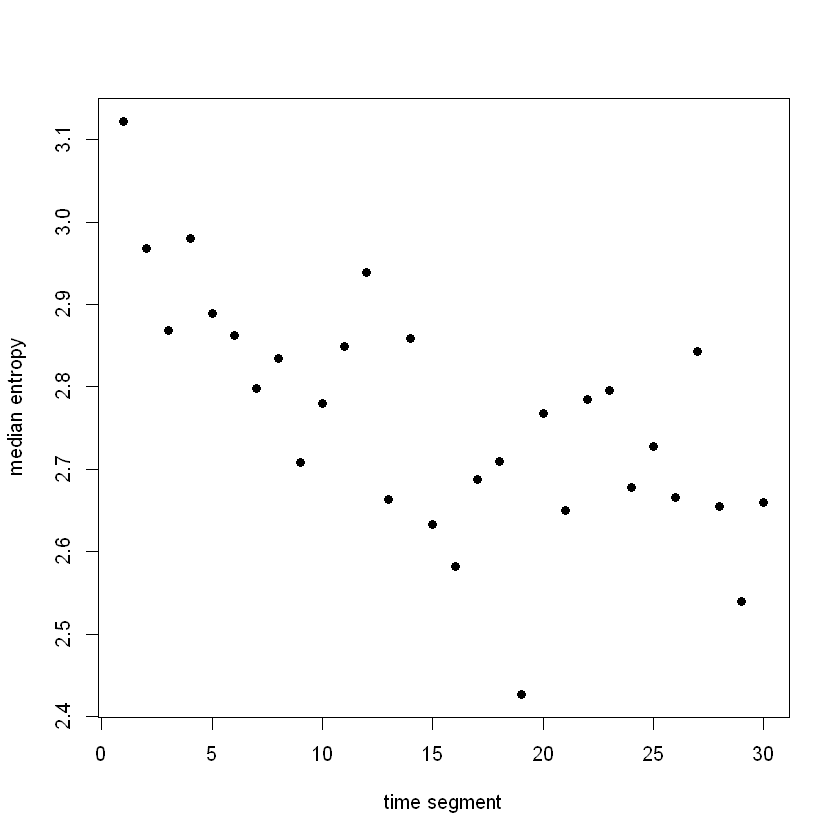

In [21]:
plot(t,et,xlab="time segment",ylab = "median entropy",pch=16)

In [22]:
entropyByLastChange <- function(a){
  #a is the result of getAllEntropies
  #here we save the entropy corresponding to the last change
  w <- vector()
  n <- dim(a$allEntropy)
  n <- n[1]
  
  for(i in 1:n[1]){
    w[i] <- a$allEntropy[i,a$indexlastchange[i]]
  }
  return(w)
  
}

In [23]:
elast <- entropyByLastChange(a)

In [25]:
PI <- matrix(data = c(pq$there,pq$reality,pq$place,pq$virtualplace),nrow=29,ncol=4)
PI_median <- apply(PI,1,median)

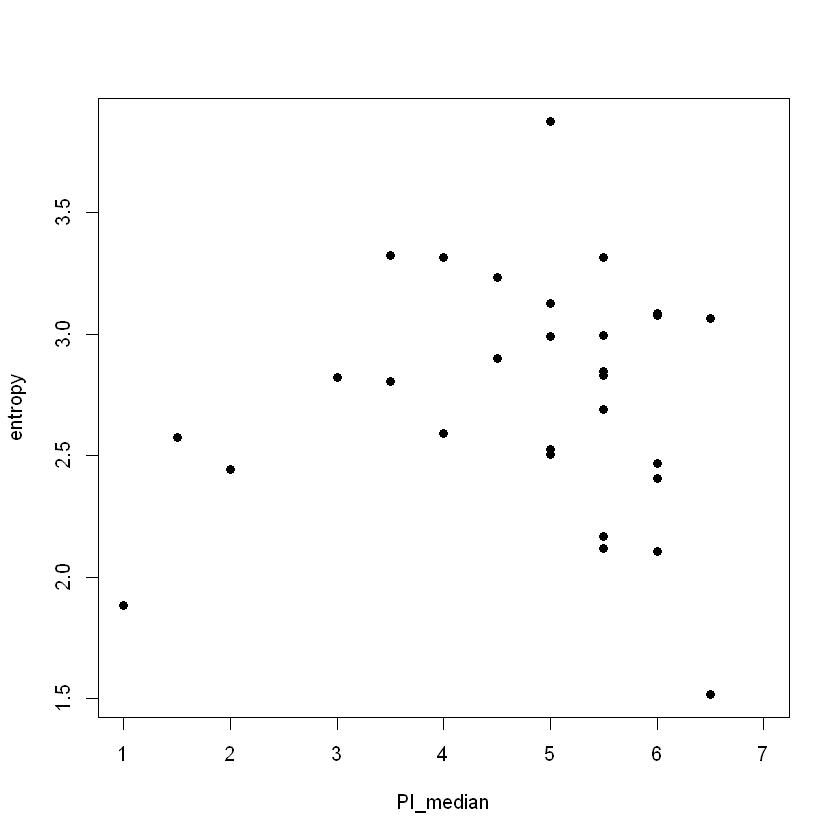

In [26]:
plot(PI_median,elast,xlab="PI_median",ylab="entropy",xlim=c(1,7), pch=16)

In [27]:
PI_median2 <- PI_median^2
lm <- lm(elast ~ PI_median + PI_median2)
summary(lm)

cor.test(elast[PI_median>=3],PI_median[PI_median>=3])


Call:
lm(formula = elast ~ PI_median + PI_median2)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8005 -0.2095 -0.0914  0.2643  0.9476 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  1.17197    0.54851   2.137  0.04221 * 
PI_median    0.93495    0.29391   3.181  0.00378 **
PI_median2  -0.11674    0.03668  -3.183  0.00376 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4391 on 26 degrees of freedom
Multiple R-squared:  0.2823,	Adjusted R-squared:  0.2271 
F-statistic: 5.113 on 2 and 26 DF,  p-value: 0.01341



	Pearson's product-moment correlation

data:  elast[PI_median >= 3] and PI_median[PI_median >= 3]
t = -1.8713, df = 24, p-value = 0.07354
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.65381454  0.03541412
sample estimates:
       cor 
-0.3568328 


In [28]:
#Running 1000 times doesn't work on Kaggle, it takes too long.
#Instead I will illustrate it with 10 times.
#let's sample over the time periods and the number of states
#the total time is 20 minutes so let's sample randomly


e10 <- rep(0,29)
N <- 10
for(i in 1:N) {
  ntime <- round(runif(1,5,40))
  nstates <- round(runif(1,3,30))
  a <- getAllEntropies(ntime,nstates)
  e10 <- e10 + entropyByLastChange(a)
  cat("i = ",i," ","ntime = ",ntime,"nstates = ",nstates, "\n")
  flush.console()
}
e10 <- e10/N


1   100 
2   101 
3   102 
4   103 
5   104 
6   105 
7   106 
8   107 
9   108 
10   109 
11   110 
12   111 
13   112 
14   113 
15   114 
16   115 
17   116 
18   117 
19   118 
20   119 
21   120 
22   121 
23   122 
24   123 
25   124 
26   126 
27   127 
28   128 
29   129 
i =  1   ntime =  22 nstates =  29 
1   100 
2   101 
3   102 
4   103 
5   104 
6   105 
7   106 
8   107 
9   108 
10   109 
11   110 
12   111 
13   112 
14   113 
15   114 
16   115 
17   116 
18   117 
19   118 
20   119 
21   120 
22   121 
23   122 
24   123 
25   124 
26   126 
27   127 
28   128 
29   129 
i =  2   ntime =  37 nstates =  26 
1   100 
2   101 
3   102 
4   103 
5   104 
6   105 
7   106 
8   107 
9   108 
10   109 
11   110 
12   111 
13   112 
14   113 
15   114 
16   115 
17   116 
18   117 
19   118 
20   119 
21   120 
22   121 
23   122 
24   123 
25   124 
26   126 
27   127 
28   128 
29   129 
i =  3   ntime =  25 nstates =  29 
1   100 
2   101 
3   102 
4   103 
5   104 
6   

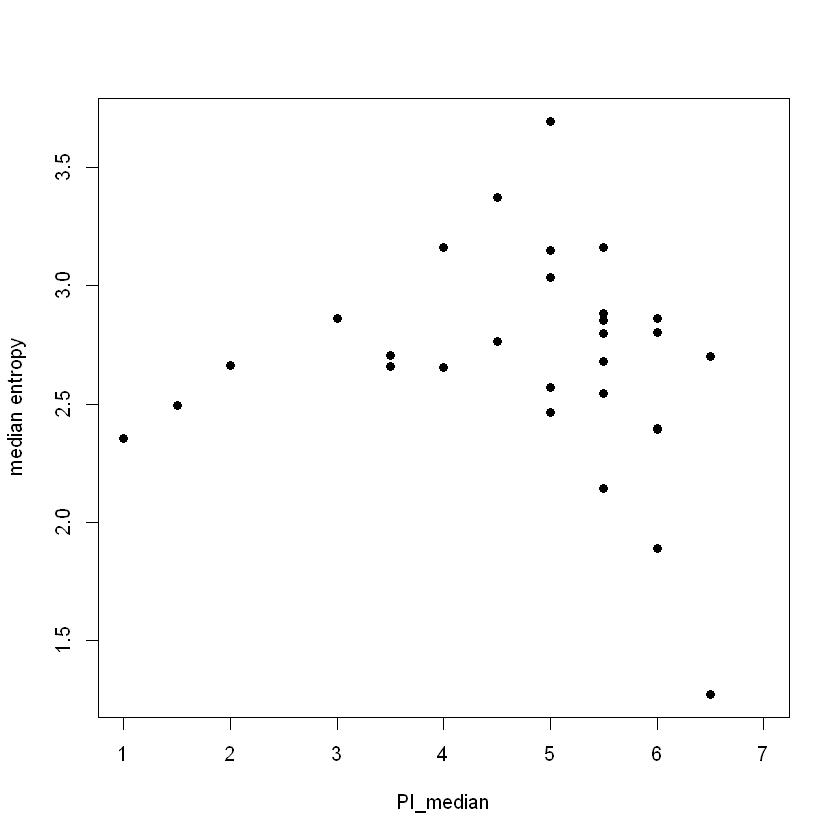

In [29]:
plot(PI_median,e10,xlim=c(1,7),ylab="median entropy", pch=16)


In [30]:
#Stan analysis
library("rstan")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

In [31]:
mydata <- list(
            N = length(PI_median),
            pres = PI_median,
            entropy = e10
)


In [32]:
stan_model <- "
data {
  int<lower=0> N;       // Number of data points
  vector[N] pres;       // Independent variable
  vector[N] entropy;    // Dependent variable
}

parameters {
  vector[3] b;                 
  real<lower=0> sigma;      
  real<lower=1> v;      //degrees of freedom
}

model {
  // Priors
  b ~ normal(0, 10);
  sigma ~ gamma(2,0.1);
  v ~ gamma(2,0.1);

  // Likelihood
  for(i in 1:N) {
      entropy[i] ~ student_t(v, b[1] + b[2]*pres[i] + b[3]*(pres[i]^2), sigma);
  }
}

generated quantities {
  vector[N] entropy_new;
  vector[N] log_lik_entropy;
  real m;
  
  for(i in 1:N){
    m = b[1] + b[2]*pres[i] + b[3]*(pres[i]^2);
    entropy_new[i] = student_t_rng(v,m, sigma);
    log_lik_entropy[i] = student_t_lpdf(entropy[i]|v,m, sigma);
  }
}
"

In [33]:
fit <- stan (model_code = stan_model, # Stan program
              data = mydata, # named list of data
              chains = 4, # number of Markov chains
              iter = 3000, # total number of iterations per chain
              cores = 4,
              #control = list(max_treedepth = 12),
              seed=54321)


Warning message:
No C++ compiler found, so the following will probably not work.rl-sm-vr/lib/R/bin//R" CMD config CXX' renvoie un statut 1"
See https://github.com/stan-dev/rstan/wiki/Installing-RStan-on-Windows#toolchain
Warning message:
"l'exécution de la commande 'C:/Users/JoanLlobera/.conda/envs/rl-sm-vr/lib/R/bin/x64/R CMD SHLIB file812c1d7b1bde.cpp 2> file812c1d7b1bde.cpp.err.txt' renvoie un statut 1"

Warning message:
l'exécution de la commande 'make -f "C:/Users/JOANLL~1/CONDA~1/envs/rl-sm-vr/lib/R/etc/x64/Makeconf" -f "C:/Users/JOANLL~1/CONDA~1/envs/rl-sm-vr/lib/R/share/make/winshlib.mk" SHLIB_LDFLAGS='$(SHLIB_CXXLDFLAGS)' SHLIB_LD='$(SHLIB_CXXLD)' SHLIB="file812c1d7b1bde.dll" WIN=64 TCLBIN=64 OBJECTS="file812c1d7b1bde.o"' renvoie un statut 127 

ERROR(s) during compilation: source code errors or compiler configuration errors!

Program source:
  1: 
  2: // includes from the plugin
  3: 
  4: 
  5: // user includes
  6: #define STAN__SERVICES__COMMAND_HPP// Code generated by Stan version 2.17.0
  7: 
  8: #include <stan/model/model_header.hpp>
  9: 
 10: namespace model812c709c2c5b_d7ecb0ca6312ce1acf6752b5ea055bd8_namespace {
 11: 
 12: using std::istream;
 13: using std::string;
 14: using std::stringstream;
 15: using std::vector;
 16: using stan::io::dump;
 17: using stan::math::lgamma;
 18: using stan::model::prob_grad;
 19: using namespace stan::math;
 20: 
 21: typedef Eigen

ERROR: Error in compileCode(f, code, language = language, verbose = verbose): Compilation ERROR, function(s)/method(s) not created! Warning message:
l'exécution de la commande 'make -f "C:/Users/JOANLL~1/CONDA~1/envs/rl-sm-vr/lib/R/etc/x64/Makeconf" -f "C:/Users/JOANLL~1/CONDA~1/envs/rl-sm-vr/lib/R/share/make/winshlib.mk" SHLIB_LDFLAGS='$(SHLIB_CXXLDFLAGS)' SHLIB_LD='$(SHLIB_CXXLD)' SHLIB="file812c1d7b1bde.dll" WIN=64 TCLBIN=64 OBJECTS="file812c1d7b1bde.o"' renvoie un statut 127 


In [ ]:
print(fit, pars=c("b","sigma","v"),probs=c(.025,.975))

In [ ]:
e <- rstan::extract(fit)

In [ ]:
#probabilities of the parameters being positive
mean(e$b[,1]>0)
mean(e$b[,2]>0)
mean(e$b[,3]>0)

In [ ]:
#find the probability that the degrees of freedom might be less than 30
mean(e$v < 30)

In [ ]:
#obtain the means of the parameters forming the quadratic
b0 <- mean(e$b[,1])
b1 <- mean(e$b[,2])
b2 <- mean(e$b[,3])

In [ ]:
#now plot the quadratic over the data points
p <- seq(1,7,0.1)
ent <- b0 + b1*p + b2*(p^2)

In [ ]:
sz <- 1.5
plot(p, ent, type="l", ylim=c(1,3.5), xlim=c(1,7), xlab="", ylab="", 
     cex.lab=sz, cex.axis=sz)
par(new=TRUE)
plot(PI_median, e10, ylim=c(1,3.5), xlim=c(1,7), ylab="entropy", 
     pch=16, cex.lab=sz, cex.axis=sz)


In [ ]:
#plot observed against predicted posterior distribution means
plot(e10,apply(e$entropy_new,2,mean))
cor.test(e10,apply(e$entropy_new,2,mean))

In [ ]:
loo_summary <- function(fit, name) {

  log_lik <- extract_log_lik(fit, merge_chains = FALSE,parameter_name=name)
  r_eff <- relative_eff(exp(log_lik))
  loo <- loo(log_lik, r_eff = r_eff, cores = 2)
  return(loo)
}

In [ ]:
library("loo")
loo <- loo_summary(fit,"log_lik_entropy")
loo